In [1]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Conv2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Максимальное количество слов 
num_words = 40000
# Максимальная длина новости
max_news_len = 20

## Загрузка набора данных

Загружаем данные для обучения

In [3]:
from sklearn.utils import shuffle

num_words = 40000
max_news_len = 20

text_test = pd.read_csv("test_new.csv").dropna().text
text_train = pd.read_csv("train_new.csv").dropna().text
label_test = pd.read_csv("test_new.csv").dropna().title*1
label_train = pd.read_csv("train_new.csv").dropna().title

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(text_train)
sequences = tokenizer.texts_to_sequences(text_train)
x_train = pad_sequences(sequences, maxlen=max_news_len, value=0, padding='post')
x_train[:20]

x_train, y_train = shuffle(x_train, label_train, random_state=0)

## Сверточная нейронная сеть

In [5]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional, Flatten, BatchNormalization, LSTMCell, RNN, GRU
import tensorflow as tf

model_cnn = Sequential()
model_cnn.add(Embedding(num_words,  100, input_length=max_news_len))
model_cnn.add(LSTM(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))


In [6]:
from tensorflow.keras.metrics import Precision, Recall
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model_cnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(name='Recall'), Precision(name='Precision'), f1_metric])

In [9]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           4000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,125,569
Trainable params: 4,125,569
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл `best_model.h5`

In [122]:
model_cnn_save_path = 'best_model_cnn.h5'
checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      # save_best_only=True,
                                      verbose=1)

In [13]:
history_cnn = model_cnn.fit(x_trai, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            # callbacks=[checkpoint_callback_cnn]
                            )

499/499 [==============================] - 31s 62ms/step - loss: 0.5458 - accuracy: 0.7302 - Recall: 0.1885 - Precision: 0.5762 - f1_metric: 0.2772 - val_loss: 0.8639 - val_accuracy: 0.6926 - val_Recall: 0.0649 - val_Precision: 0.3082 - val_f1_metric: 0.1034


In [12]:
X = np.vstack((x_train,x_test))
Y = np.array(pd.concat((label_train, label_test), axis = 0).to_list())

In [13]:
# НОВОЕ ОБУЧЕНИЕ
test_sequences = tokenizer.texts_to_sequences(text_test)	
x_test = pad_sequences(test_sequences, maxlen=max_news_len, value=0, padding='post')

history_cnn = model_cnn.fit(X, 
                            Y, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            # callbacks=[checkpoint_callback_cnn]
                            )

model_cnn.save_weights('SASHA_my_model_weights.h5')

Epoch 1/5
548/548 [==============================] - 46s 79ms/step - loss: 0.6105 - accuracy: 0.7069 - Recall: 0.0082 - Precision: 0.2095 - f1_metric: 0.0042 - val_loss: 0.3833 - val_accuracy: 0.9707 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 2/5
548/548 [==============================] - 43s 78ms/step - loss: 0.5907 - accuracy: 0.7121 - Recall: 9.9474e-04 - Precision: 0.2803 - f1_metric: 0.0019 - val_loss: 0.3877 - val_accuracy: 0.9707 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_f1_metric: 0.0000e+00
Epoch 3/5
548/548 [==============================] - 43s 79ms/step - loss: 0.5450 - accuracy: 0.7258 - Recall: 0.1294 - Precision: 0.5996 - f1_metric: 0.2025 - val_loss: 0.4049 - val_accuracy: 0.9347 - val_Recall: 0.0526 - val_Precision: 0.0395 - val_f1_metric: 0.0079
Epoch 4/5
548/548 [==============================] - 43s 78ms/step - loss: 0.5062 - accuracy: 0.7446 - Recall: 0.3060 - Precision: 0.6190 - f1_metric: 0.3972 - val_l

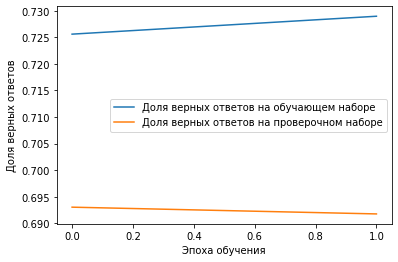

In [127]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import f1_score

# def threshold_answ(label_predict, threshold = 0.50):
#   label_predict_step = []
#   for lab in label_predict:
#     if lab >= threshold :
#       label_predict_step.append(1);
#     else:
#       label_predict_step.append(0);    
#   return label_predict_step

test_sequences = tokenizer.texts_to_sequences(text_test)	
x_test = pad_sequences(test_sequences, maxlen=max_news_len, value=0, padding='post')

label_predict = model_cnn.predict_classes(x_test)
# label_predict_step = threshold_answ(label_predict)


# pd.DataFrame([label_predict_step, label_test.to_list()])
print('Оценка F1', f1_score(label_predict, label_test.to_list()))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Оценка F1 0.33659491193737767


In [133]:
model_cnn.save_weights('SASHA_my_model_weights.h5')
model_cnn.load_weights('SASHA_my_model_weights.h5')


In [ ]:
# import tensorflow_hub as hub
# %tensorflow_version 2.x
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU, Conv2D, GlobalMaxPool1D
# from tensorflow.keras import utils
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras import utils
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline 
# from tensorflow.keras.metrics import Precision, Recall

# nb_filters=50
# FFN_units=512
# nb_classes=6
# dropout_rate=0.1
# name="dcnn"


# model_4 = Sequential()

# model_4.add(hub.KerasLayer(
#       "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
#       trainable=False))
# model_4.add(Conv1D(filters=nb_filters,
#                 kernel_size=2,
#                 padding="valid",
#                 activation="relu"))
# model_4.add(Conv1D(filters=nb_filters,
#                   kernel_size=3,
#                   padding="valid",
#                   activation="relu"))
# model_4.add(Conv1D(filters=nb_filters,
#       kernel_size=4,
#       padding="valid",
#       activation="relu"))
# model_4.add(GlobalMaxPool1D())
# model_4.add(Dense(units=FFN_units, activation="relu"))
# model_4.add(Dropout(rate=dropout_rate))
# model_4.add(Dense(units=nb_classes, activation="sigmoid"))

# model_4.compile(optimizer='adam', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy', Recall(name='Recall'), Precision(name='Precision')])

In [ ]:
model_4.summary()